## PART 1 Data Acquisition

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import re
import time

# lists to store the data
ranks = []
title_lengths = []
age_in_hours = []
points = []
comment_counts = []

# Loop through the first 5 pages
for i in range(5):
    url= "https://news.ycombinator.com/?p=" + str(i+1)
    
    # read and decode page 
    with urllib.request.urlopen (url) as response:
        html = response.read()
        html = html.decode("utf-8")
    
    # save the HTML page content
    with open ("hackernews" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)
    
    # parse the HTML content stored in html and save as 'soup'
    parsedPage = BeautifulSoup(html, 'html.parser')

    #scraping rank
    for post in parsedPage.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))

    #scraping length of title
    for title in parsedPage.find_all(class_="titleline"):
        title_lengths.append(len(title.text))

    #scraping age of post
    for age  in parsedPage.find_all(class_="age"):
        age_str = str(age.text)
        age_str = age_str.removesuffix(" hours ago")
        age_str = age_str.removesuffix(" hour ago")
        
        # 1 day ago, converted to 24 hours
        if " day ago" in age_str:
            age_in_hours.append(24)
        elif " days ago" in age_str:
            modified_string = age_str.replace(" days ago", "")
            age_int = int(modified_string)
            age_in_hours.append(24*age_int)
        elif " minutes ago" in age_str:
            age_in_hours.append(0)
        elif " minute ago" in age_str:
            age_in_hours.append(0)
        else:
            age_in_hours.append(int(age_str))

    #scraping points and comments
    for subtext in parsedPage.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            # extract the number from the text
            point = int(re.search(r'\d+', str(score.text)).group())

        for anchorTag in subtext.find_all("a"):
            if anchorTag.text.endswith("comments"):
                a_string = str(anchorTag.text)
                # extract the number from the text
                comments = int(re.search(r'\d+', a_string).group())
        comment_counts.append(int(comments))
        points.append(int(point))
    
    # avoid overloading the server    
    time.sleep(5)


# creating a data frame
submissions_df = pd.DataFrame({"rank": ranks, "title_lengths": title_lengths, "age_in_hours": age_in_hours, "points": points, "comment_counts": comment_counts})
print(submissions_df)

# save as csv file
submissions_df.to_csv('hackerPosts.csv', index=False)

     rank  title_lengths  age_in_hours  points  comment_counts
0       1             74             1      48              11
1       2             93            14     848             157
2       3             80             0       7               0
3       4             78             2      40              20
4       5             34            11     295             290
..    ...            ...           ...     ...             ...
145   146             81            48     100              70
146   147             60            48     351              93
147   148             43            48      50               4
148   149             89            10       8               0
149   150             23             9      31              17

[150 rows x 5 columns]


## Part 2 Regression

In [2]:
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

submissions_df = pd.read_csv('hackerPosts.csv')

# rank predicted by comment_counts, points, and age_in_hours
count_points_age_ols = sm.ols(formula="rank ~ comment_counts + points + age_in_hours", data=submissions_df).fit()
count_points_age_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     23.68
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.51e-12
Time:                        20:44:37   Log-Likelihood:                -748.33
No. Observations:                 150   AIC:                             1505.
Df Residuals:                     146   BIC:                             1517.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         55.5418      4.522     12.282      0.000      46.605      64.479
comment_counts     0.0212      0.048      0.441      0.660      -0.074       0.116
points            -0.1223      0.031     -3.980      0.000      -0.183      -0.062
age_in_hours       2.1391      0.255      8.386      0.000       1.635       2.643
==============================================================================
Omnibus:                        8.382   Durbin-Watson:                   0.672
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                5.106
Skew:                           0.282   Prob(JB):                       0.0778
Kurtosis:                       2.294   Cond. No.                         291.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by comment_counts, points, and age_in_hours
R squared = .336
P value:
- comment_counts = .459
- points = 0.0
- age_in_hours = 0.0


In [3]:
#rank predicted by age
age_rank_ols = sm.ols(formula="rank ~ age_in_hours", data=submissions_df).fit()
age_rank_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     42.75
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           9.46e-10
Time:                        20:44:37   Log-Likelihood:                -759.03
No. Observations:                 150   AIC:                             1522.
Df Residuals:                     148   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       52.5266      4.709     11.155      0.000      43.221      61.832
age_in_hours     1.5523      0.237      6.539      0.000       1.083       2.021
==============================================================================
Omnibus:                        8.479   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                4.251
Skew:                           0.174   Prob(JB):                        0.119
Kurtosis:                       2.252   Cond. No.                         29.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by age_in_hours

R-squared = .257
P value = 0.00

In [4]:
#rank predicted points + comments
rank_points_ols = sm.ols(formula="rank ~ comment_counts + points", data=submissions_df).fit()
rank_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2467
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.782
Time:                        20:44:37   Log-Likelihood:                -777.81
No. Observations:                 150   AIC:                             1562.
Df Residuals:                     147   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         77.3582      4.487     17.241      0.000      68.491      86.225
comment_counts    -0.0172      0.058     -0.297      0.767      -0.132       0.097
points            -0.0100      0.034     -0.297      0.767      -0.076       0.056
==============================================================================
Omnibus:                       71.862   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.475
Skew:                           0.022   Prob(JB):                      0.00876
Kurtosis:                       1.770   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by comment_counts and points

R-squared = 0
P-value:
- comment count = .993
- points = .940

In [5]:
#rank predicted by points + age
rank_points_ols = sm.ols(formula="rank ~ points + age_in_hours", data=submissions_df).fit()
rank_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     35.62
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.43e-13
Time:                        20:44:37   Log-Likelihood:                -748.43
No. Observations:                 150   AIC:                             1503.
Df Residuals:                     147   BIC:                             1512.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       55.8428      4.458     12.526      0.000      47.033      64.653
points          -0.1139      0.024     -4.725      0.000      -0.162      -0.066
age_in_hours     2.1283      0.253      8.405      0.000       1.628       2.629
==============================================================================
Omnibus:                        8.512   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                5.336
Skew:                           0.301   Prob(JB):                       0.0694
Kurtosis:                       2.299   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by points and age
R-squared = .336
P value:
- points = 0.0
- age = 0.0


### Observations
The closer a R-square value is to 1, the stronger the correlation and the closer a P-value is to 0 the more significant the prediction is. 

Based off this, we can determine points and age together are the best indicator of rank, with their model explaining 36.6% of variability in rank. 

The coeff for points is -0.1133 and for age is 2.2187. This is note worthy because it means that as points go up, the rank will go slightly down. 




## Part 3 Classification

Optimization terminated successfully.
         Current function value: 0.407700
         Iterations 6


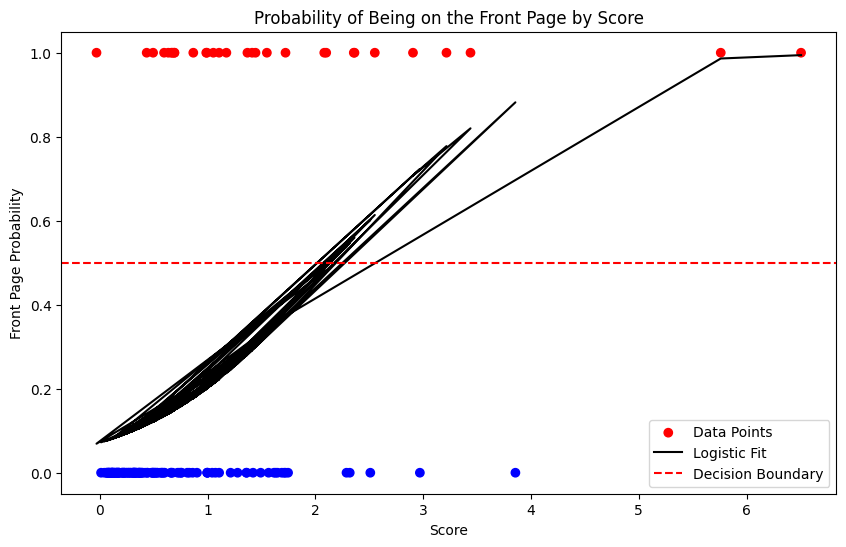

                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Jun 2024   Pseudo R-squ.:                  0.1853
Time:                        20:44:40   Log-Likelihood:                -61.155
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 1.338e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5647      0.367     -6.989      0.000      -3.284      -1.845
Score          1.1866      0.273      4.347      0.000       0.652       1.722


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Compute 'Front Page' binary variable
submissions_df['Front Page'] = np.where(submissions_df['rank'] <= 30, 1, 0)
# Add 'Score' column (post's engagement relative to its age and points)
submissions_df['Score'] = (submissions_df['points'] - 1) / (submissions_df['age_in_hours'] + 2) ** 1.8

# Logistic Regression Model
logit_model = sm.Logit(submissions_df['Front Page'], sm.add_constant(submissions_df[['Score']]))
result = logit_model.fit()

# PLOT
plt.figure(figsize=(10, 6))

# scatter plot data points are colored based on their front page status
plt.scatter(submissions_df['Score'], submissions_df['Front Page'], c=['red' if x else 'blue' for x in submissions_df['Front Page']], label='Data Points')

# logistic regression curve 
predicted_probs = result.predict(sm.add_constant(submissions_df[['Score']]))
plt.plot(submissions_df['Score'], predicted_probs, color='black', label='Logistic Fit')

# decision boundary
plt.axhline(0.5, color='red', linestyle='--', label='Decision Boundary')

plt.xlabel('Score')
plt.ylabel('Front Page Probability')
plt.title('Probability of Being on the Front Page by Score')
plt.legend()
plt.show()

# Print the summary of the logistic regression
print(result.summary())


**Pseudo R-squared (0.1853):**  The model explains about 18.53% of the variability in the front page status, which is relatively poor explanatory power.

**Log-Likelihood and LL-Null:** The log-likelihood of the model is -61.155, compared to -75.060 for the model with no predictors (LL-Null). This improvement indicates that the model with predictors fits the data significantly better than a null model.

**Score Coefficient:** 1.1866 with a standard error of 0.273. This positive coefficient indicates that higher scores significantly increase the log odds of a post being on the front page. The coefficient is statistically significant (P < 0.001), showing strong evidence that higher engagement relative to their age and points are more likely to appear on the front page.